# K-NN Classification

In [46]:
# Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from skopt import BayesSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 

## Read Datasets

In [2]:
df_day_minus_0 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_0.csv')
df_day_minus_1 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_1.csv')
df_day_minus_2 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_2.csv')
df_day_minus_7 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_7.csv')

C:\Users\ali_m\AppData\Local\Temp\ipykernel_42224\2795191405.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_day_minus_0 = pd.read_csv('C:/com748/code/com748/data/processed/balanced_dataset/day_minus_0.csv')


Handle missing values

In [3]:
df_day_minus_0 = df_day_minus_0.drop(columns=['date','file_date'], axis=1)
df_day_minus_1 = df_day_minus_1.drop(columns=['date'], axis=1)
df_day_minus_2 = df_day_minus_2.drop(columns=['date'], axis=1)
df_day_minus_7 = df_day_minus_7.drop(columns=['date'], axis=1)

df_day_minus_0['null_columns'] = df_day_minus_0.isnull().sum(axis=1)
df_day_minus_1['null_columns'] = df_day_minus_1.isnull().sum(axis=1)
df_day_minus_2['null_columns'] = df_day_minus_2.isnull().sum(axis=1)
df_day_minus_7['null_columns'] = df_day_minus_7.isnull().sum(axis=1)

df_day_minus_0 = df_day_minus_0[df_day_minus_0.null_columns == 0]
df_day_minus_1 = df_day_minus_1[df_day_minus_1.null_columns == 0]
df_day_minus_2 = df_day_minus_2[df_day_minus_2.null_columns == 0]
df_day_minus_7 = df_day_minus_7[df_day_minus_7.null_columns == 0]

Split into x and y

In [4]:
X_0 = df_day_minus_0.drop(columns=['failure', 'serial_number', 'null_columns'], axis=1)
X_1 = df_day_minus_1.drop(columns=['failure', 'serial_number', 'null_columns'], axis=1)
X_2 = df_day_minus_2.drop(columns=['failure', 'serial_number', 'null_columns'], axis=1)
X_7 = df_day_minus_7.drop(columns=['failure', 'serial_number', 'null_columns'], axis=1)

Y_0 = df_day_minus_0['failure']
Y_1 = df_day_minus_1['failure']
Y_2 = df_day_minus_2['failure']
Y_7 = df_day_minus_7['failure']

One-hot encode category columns

In [9]:
X_0 = pd.get_dummies(X_0, prefix=['model'], dtype=int)
X_1 = pd.get_dummies(X_1, prefix=['model'], dtype=int)
X_2 = pd.get_dummies(X_2, prefix=['model'], dtype=int)
X_7 = pd.get_dummies(X_7, prefix=['model'], dtype=int)


Split into training and test

In [10]:
encoder_0 = ce.OrdinalEncoder(cols=['capacity_bytes'])
encoder_1 = ce.OrdinalEncoder(cols=['capacity_bytes'])
encoder_2 = ce.OrdinalEncoder(cols=['capacity_bytes'])
encoder_7 = ce.OrdinalEncoder(cols=['capacity_bytes'])

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, Y_0, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, Y_7, test_size=0.2, random_state=42)

X_train_0 = encoder_0.fit_transform(X_train_0)
X_test_0 = encoder_0.transform(X_test_0)

X_train_1 = encoder_1.fit_transform(X_train_1)
X_test_1 = encoder_1.transform(X_test_1)

X_train_2 = encoder_2.fit_transform(X_train_2)
X_test_2 = encoder_2.transform(X_test_2)

X_train_7 = encoder_0.fit_transform(X_train_7)
X_test_7 = encoder_0.transform(X_test_7)

Scale data

In [11]:
from sklearn.preprocessing import RobustScaler

# Fit and transform training data
r_scaler_0 = RobustScaler()
scaled_X_train_0 = X_train_0.copy()
scaled_X_train_0[scaled_X_train_0.columns] = r_scaler_0.fit_transform(scaled_X_train_0[scaled_X_train_0.columns])

r_scaler_1 = RobustScaler()
scaled_X_train_1 = X_train_1.copy()
scaled_X_train_1[scaled_X_train_1.columns] = r_scaler_1.fit_transform(scaled_X_train_1[scaled_X_train_1.columns])

r_scaler_2 = RobustScaler()
scaled_X_train_2 = X_train_2.copy()
scaled_X_train_2[scaled_X_train_2.columns] = r_scaler_2.fit_transform(scaled_X_train_2[scaled_X_train_2.columns])

r_scaler_7 = RobustScaler()
scaled_X_train_7 = X_train_7.copy()
scaled_X_train_7[scaled_X_train_7.columns] = r_scaler_7.fit_transform(scaled_X_train_7[scaled_X_train_7.columns])

# Transform test data
scaled_X_test_0 = X_test_0.copy()
scaled_X_test_0[scaled_X_test_0.columns] = r_scaler_0.transform(scaled_X_test_0[scaled_X_test_0.columns])

scaled_X_test_1 = X_test_1.copy()
scaled_X_test_1[scaled_X_test_1.columns] = r_scaler_1.transform(scaled_X_test_1[scaled_X_test_1.columns])

scaled_X_test_2 = X_test_2.copy()
scaled_X_test_2[scaled_X_test_2.columns] = r_scaler_2.transform(scaled_X_test_2[scaled_X_test_2.columns])

scaled_X_test_7 = X_test_7.copy()
scaled_X_test_7[scaled_X_test_7.columns] = r_scaler_7.transform(scaled_X_test_7[scaled_X_test_7.columns])


Hyperparameter Tuning

In [17]:
param_grid = {
    'n_neighbors': list(range(1, 61)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': list(range(1, 61)),
    'p': [1, 2]
}

knn_model_0_cv = KNeighborsClassifier()

rand_search_0 = RandomizedSearchCV(knn_model_0_cv, param_grid, cv=5, scoring='roc_auc', n_iter=200)
rand_search_0.fit(scaled_X_train_0, y_train_0)

print(rand_search_0.best_params_)

df_randsearch_results_0 = pd.DataFrame(rand_search_0.cv_results_)

# {'weights': 'uniform', 'p': 2, 'n_neighbors': 39, 'leaf_size': 36, 'algorithm': 'ball_tree'}

{'weights': 'uniform', 'p': 2, 'n_neighbors': 39, 'leaf_size': 36, 'algorithm': 'ball_tree'}


# Train Models

Day minus 0

In [18]:
# Best params: {'weights': 'uniform', 'p': 2, 'n_neighbors': 39, 'leaf_size': 36, 'algorithm': 'ball_tree'}

knn_model_0 = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=39, leaf_size=36, algorithm='ball_tree')
knn_model_0.fit(scaled_X_train_0, y_train_0)

test_predictions_0 = knn_model_0.predict(scaled_X_test_0)
cm = confusion_matrix(y_true=y_test_0, y_pred=test_predictions_0)
print(cm)

# Evaluate the model on test set
test_accuracy_0 = knn_model_0.score(scaled_X_test_0, y_test_0)
print("Test Accuracy:", test_accuracy_0)

[[2473  207]
 [ 867 1856]]
Test Accuracy: 0.8012215435868961


In [20]:
from sklearn.inspection import permutation_importance
r_0 = permutation_importance(knn_model_0, scaled_X_test_0, y_test_0,
                           n_repeats=5,
                           random_state=67,
                           scoring='roc_auc')

for i in r_0.importances_mean.argsort()[::-1]:
    if r_0.importances_mean[i] - 2 * r_0.importances_std[i] > 0:
        print(f"{scaled_X_test_0.columns[i]:<8}\t\t"
              f"{r_0.importances_mean[i]:.3f}"
              f" +/- {r_0.importances_std[i]:.3f}")

smart_5_raw		0.114 +/- 0.004
smart_198_raw		0.072 +/- 0.005
smart_197_raw		0.072 +/- 0.005
smart_187_raw		0.052 +/- 0.004
smart_187_normalized		0.045 +/- 0.003
smart_188_raw		0.034 +/- 0.003
smart_242_raw		0.031 +/- 0.002
smart_240_raw		0.022 +/- 0.002
smart_192_raw		0.015 +/- 0.001
smart_7_raw		0.007 +/- 0.001
smart_241_raw		0.006 +/- 0.002
smart_199_raw		0.003 +/- 0.001
smart_9_raw		0.003 +/- 0.001
smart_9_normalized		0.002 +/- 0.001
smart_3_normalized		0.002 +/- 0.001
smart_4_raw		0.002 +/- 0.001
smart_12_raw		0.002 +/- 0.001
capacity_bytes		0.001 +/- 0.000
model_ST8000DM002		0.001 +/- 0.000
model_ST12000NM0007		0.000 +/- 0.000
model_ST14000NM001G		0.000 +/- 0.000


                      mean_importance  std_importance               feature
smart_194_normalized        -0.000379        0.000265  smart_194_normalized
smart_194_raw               -0.000379        0.000265         smart_194_raw
smart_190_normalized        -0.000379        0.000265  smart_190_normalized
smart_190_raw               -0.000379        0.000265         smart_190_raw
model_ST4000DM000           -0.000164        0.000264     model_ST4000DM000
model_ST8000NM0055          -0.000069        0.000285    model_ST8000NM0055
smart_1_raw                 -0.000030        0.000672           smart_1_raw
smart_3_raw                  0.000000        0.000000           smart_3_raw
smart_192_normalized         0.000000        0.000000  smart_192_normalized
smart_188_normalized         0.000000        0.000000  smart_188_normalized
smart_197_normalized         0.000000        0.000000  smart_197_normalized
smart_198_normalized         0.000000        0.000000  smart_198_normalized
smart_12_nor

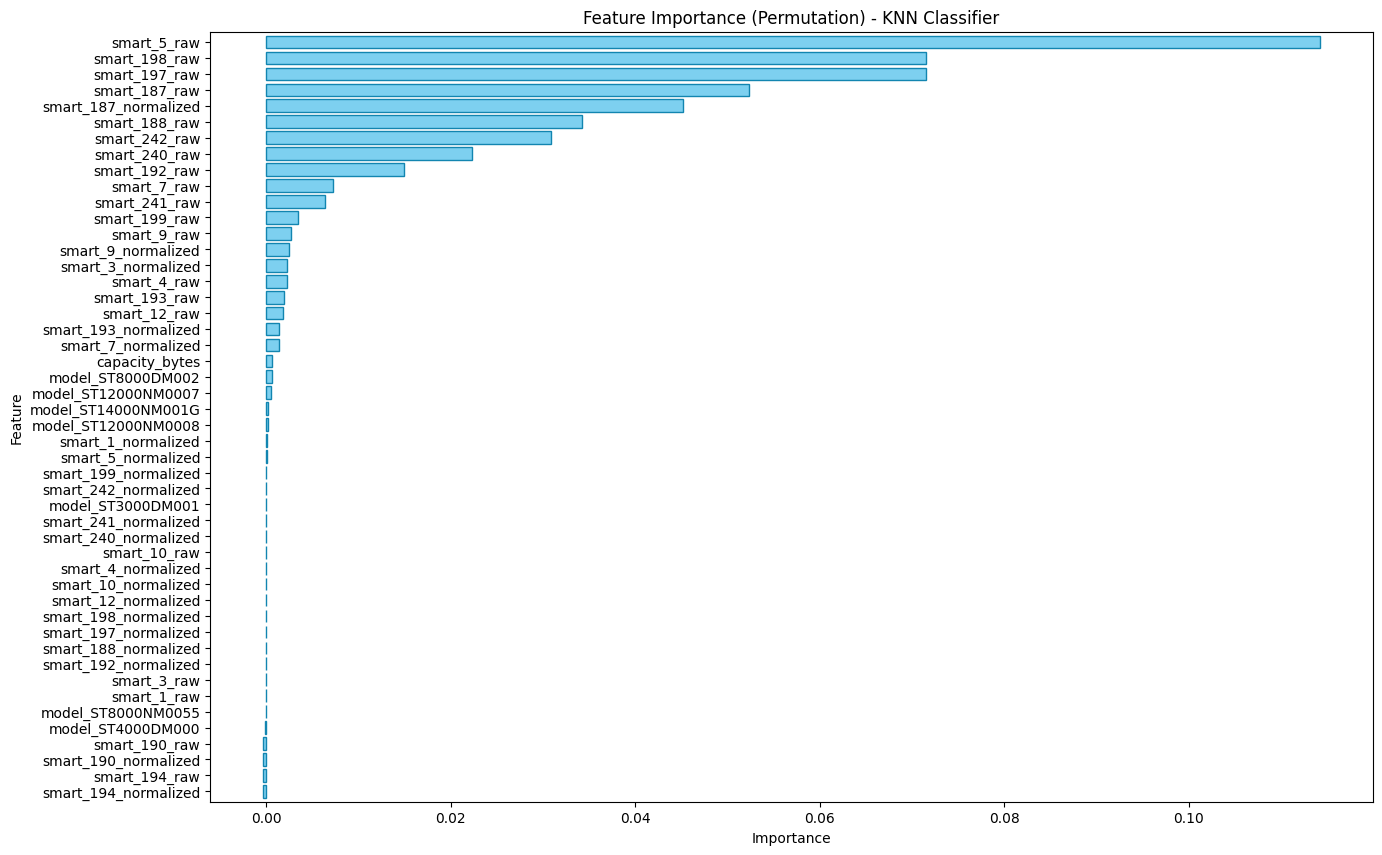

In [22]:
mean_0 = r_0.importances_mean
std_0 = r_0.importances_std
permutation_importances_0 = pd.DataFrame({'mean_importance': mean_0, 'std_importance': std_0}, index=scaled_X_test_0.columns)
permutation_importances_0['feature'] = permutation_importances_0.index
permutation_importances_0.sort_values(by=['mean_importance'], ascending=True, inplace=True)

plt.figure(figsize=(15,10))
fig = permutation_importances_0['mean_importance'].plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation) - KNN Classifier")

print(permutation_importances_0)

0.8756485658377229


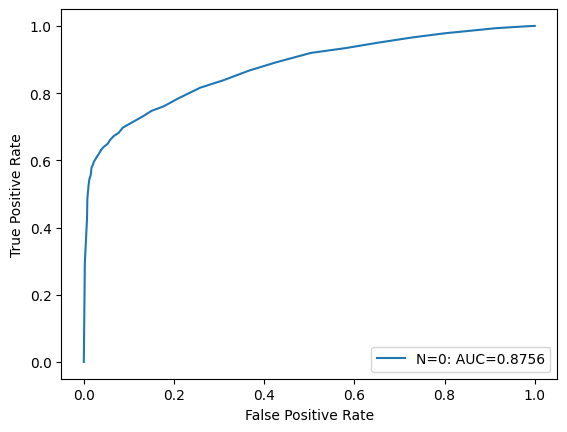

In [23]:
# Calculate AUROC
fpr_0, tpr_0, _ = roc_curve(y_test_0, knn_model_0.predict_proba(scaled_X_test_0)[:,1])
auc_0 = round(roc_auc_score(y_test_0, knn_model_0.predict_proba(scaled_X_test_0)[:,1]), 4)
plt.plot(fpr_0,tpr_0,label="N=0: AUC="+str(auc_0))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_0 = roc_auc_score(y_true=y_test_0, y_score=knn_model_0.predict_proba(scaled_X_test_0)[:,1])
print(auroc_score_0)

Day minus 1

In [24]:
knn_model_1 = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=39, leaf_size=36, algorithm='ball_tree')
knn_model_1.fit(scaled_X_train_1, y_train_1)

test_predictions_1 = knn_model_1.predict(scaled_X_test_1)
cm = confusion_matrix(y_true=y_test_1, y_pred=test_predictions_1)
print(cm)

# Evaluate the model on test set
test_accuracy_1 = knn_model_1.score(scaled_X_test_1, y_test_1)
print("Test Accuracy:", test_accuracy_1)

[[2383  234]
 [ 885 1788]]
Test Accuracy: 0.788468809073724


In [25]:
from sklearn.inspection import permutation_importance
r_1 = permutation_importance(knn_model_1, scaled_X_test_1, y_test_1,
                           n_repeats=5,
                           random_state=0,
                           scoring='roc_auc')

for i in r_1.importances_mean.argsort()[::-1]:
    if r_1.importances_mean[i] - 2 * r_1.importances_std[i] > 0:
        print(f"{scaled_X_test_1.columns[i]:<8}\t\t"
              f"{r_1.importances_mean[i]:.3f}"
              f" +/- {r_1.importances_std[i]:.3f}")

smart_5_raw		0.122 +/- 0.005
smart_198_raw		0.061 +/- 0.005
smart_197_raw		0.061 +/- 0.005
smart_187_raw		0.051 +/- 0.002
smart_187_normalized		0.051 +/- 0.002
smart_188_raw		0.031 +/- 0.001
smart_242_raw		0.025 +/- 0.003
smart_240_raw		0.024 +/- 0.001
smart_192_raw		0.020 +/- 0.003
smart_7_raw		0.005 +/- 0.001
smart_193_normalized		0.003 +/- 0.001
smart_193_raw		0.003 +/- 0.001
smart_241_raw		0.003 +/- 0.001
smart_4_raw		0.003 +/- 0.001
smart_199_raw		0.002 +/- 0.001
smart_12_raw		0.002 +/- 0.001
smart_9_normalized		0.002 +/- 0.001
smart_9_raw		0.002 +/- 0.001
smart_3_normalized		0.002 +/- 0.001
model_ST12000NM0008		0.001 +/- 0.000
model_ST8000DM002		0.000 +/- 0.000


                      mean_importance  std_importance               feature
model_ST8000NM0055          -0.000217        0.000128    model_ST8000NM0055
model_ST4000DM000           -0.000164        0.000196     model_ST4000DM000
model_ST3000DM001           -0.000003        0.000004     model_ST3000DM001
smart_4_normalized           0.000000        0.000000    smart_4_normalized
smart_10_normalized          0.000000        0.000000   smart_10_normalized
smart_3_raw                  0.000000        0.000000           smart_3_raw
smart_12_normalized          0.000000        0.000000   smart_12_normalized
smart_10_raw                 0.000000        0.000000          smart_10_raw
smart_198_normalized         0.000000        0.000000  smart_198_normalized
smart_241_normalized         0.000000        0.000000  smart_241_normalized
smart_240_normalized         0.000000        0.000000  smart_240_normalized
smart_242_normalized         0.000000        0.000000  smart_242_normalized
smart_199_no

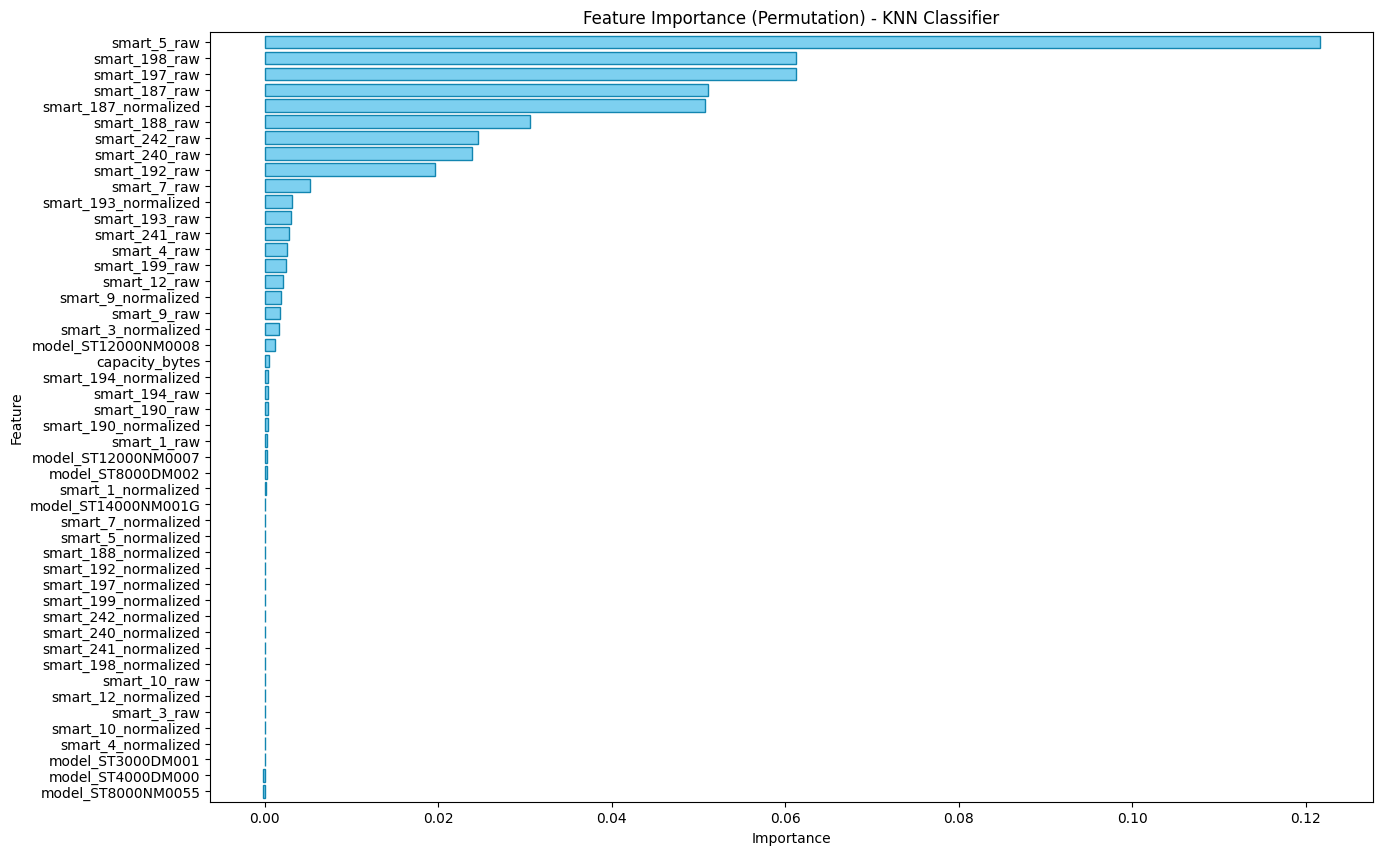

In [26]:
mean_1 = r_1.importances_mean
std_1 = r_1.importances_std
permutation_importances_1 = pd.DataFrame({'mean_importance': mean_1, 'std_importance': std_1}, index=scaled_X_test_1.columns)
permutation_importances_1['feature'] = permutation_importances_1.index
permutation_importances_1.sort_values(by=['mean_importance'], ascending=True, inplace=True)

plt.figure(figsize=(15,10))
fig = permutation_importances_1['mean_importance'].plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation) - KNN Classifier")

print(permutation_importances_1)

0.8556160538285957


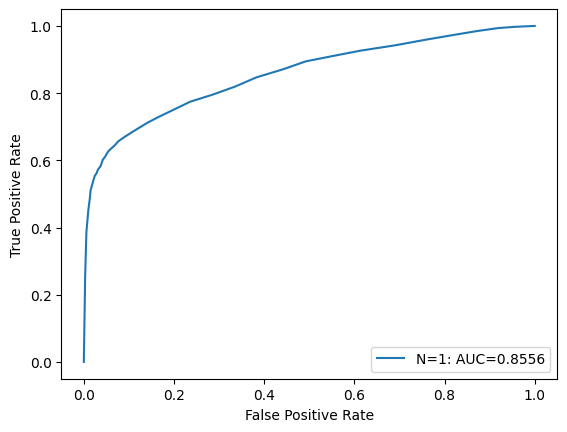

In [27]:
# Calculate AUROC
fpr_1, tpr_1, _ = roc_curve(y_test_1, knn_model_1.predict_proba(scaled_X_test_1)[:,1])
auc_1 = round(roc_auc_score(y_test_1, knn_model_1.predict_proba(scaled_X_test_1)[:,1]), 4)
plt.plot(fpr_1,tpr_1,label="N=1: AUC="+str(auc_1))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_1 = roc_auc_score(y_true=y_test_1, y_score=knn_model_1.predict_proba(scaled_X_test_1)[:,1])
print(auroc_score_1)

Day minus 2

In [28]:
knn_model_2 = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=39, leaf_size=36, algorithm='ball_tree')
knn_model_2.fit(scaled_X_train_2, y_train_2)

test_predictions_2 = knn_model_2.predict(scaled_X_test_2)
cm = confusion_matrix(y_true=y_test_2, y_pred=test_predictions_2)
print(cm)

# Evaluate the model on test set
test_accuracy_2 = knn_model_2.score(scaled_X_test_2, y_test_2)
print("Test Accuracy:", test_accuracy_2)

[[2337  277]
 [ 854 1820]]
Test Accuracy: 0.7861195158850227


In [29]:
from sklearn.inspection import permutation_importance
r_2 = permutation_importance(knn_model_2, scaled_X_test_2, y_test_2,
                           n_repeats=5,
                           random_state=0,
                           scoring='roc_auc')

for i in r_2.importances_mean.argsort()[::-1]:
    if r_2.importances_mean[i] - 2 * r_2.importances_std[i] > 0:
        print(f"{scaled_X_test_2.columns[i]:<8}\t\t"
              f"{r_2.importances_mean[i]:.3f}"
              f" +/- {r_2.importances_std[i]:.3f}")

smart_5_raw		0.123 +/- 0.005
smart_198_raw		0.066 +/- 0.003
smart_197_raw		0.066 +/- 0.003
smart_187_raw		0.065 +/- 0.004
smart_187_normalized		0.063 +/- 0.004
smart_188_raw		0.037 +/- 0.002
smart_242_raw		0.033 +/- 0.001
smart_240_raw		0.030 +/- 0.003
smart_192_raw		0.015 +/- 0.002
smart_7_raw		0.006 +/- 0.001
smart_241_raw		0.005 +/- 0.002
smart_3_normalized		0.004 +/- 0.001
smart_4_raw		0.003 +/- 0.001
smart_199_raw		0.003 +/- 0.001
smart_193_raw		0.003 +/- 0.001
smart_193_normalized		0.002 +/- 0.001
smart_12_raw		0.002 +/- 0.001
smart_9_normalized		0.002 +/- 0.001
smart_9_raw		0.002 +/- 0.001
smart_1_raw		0.002 +/- 0.001
capacity_bytes		0.001 +/- 0.000
model_ST8000NM0055		0.000 +/- 0.000
model_ST12000NM0008		0.000 +/- 0.000


                      mean_importance  std_importance               feature
model_ST8000DM002           -0.000255        0.000138     model_ST8000DM002
model_ST4000DM000           -0.000164        0.000108     model_ST4000DM000
smart_1_normalized          -0.000139        0.000368    smart_1_normalized
model_ST14000NM001G         -0.000029        0.000005   model_ST14000NM001G
model_ST3000DM001           -0.000001        0.000002     model_ST3000DM001
smart_5_normalized           0.000000        0.000000    smart_5_normalized
smart_4_normalized           0.000000        0.000000    smart_4_normalized
smart_3_raw                  0.000000        0.000000           smart_3_raw
smart_198_normalized         0.000000        0.000000  smart_198_normalized
smart_197_normalized         0.000000        0.000000  smart_197_normalized
smart_192_normalized         0.000000        0.000000  smart_192_normalized
smart_199_normalized         0.000000        0.000000  smart_199_normalized
smart_12_nor

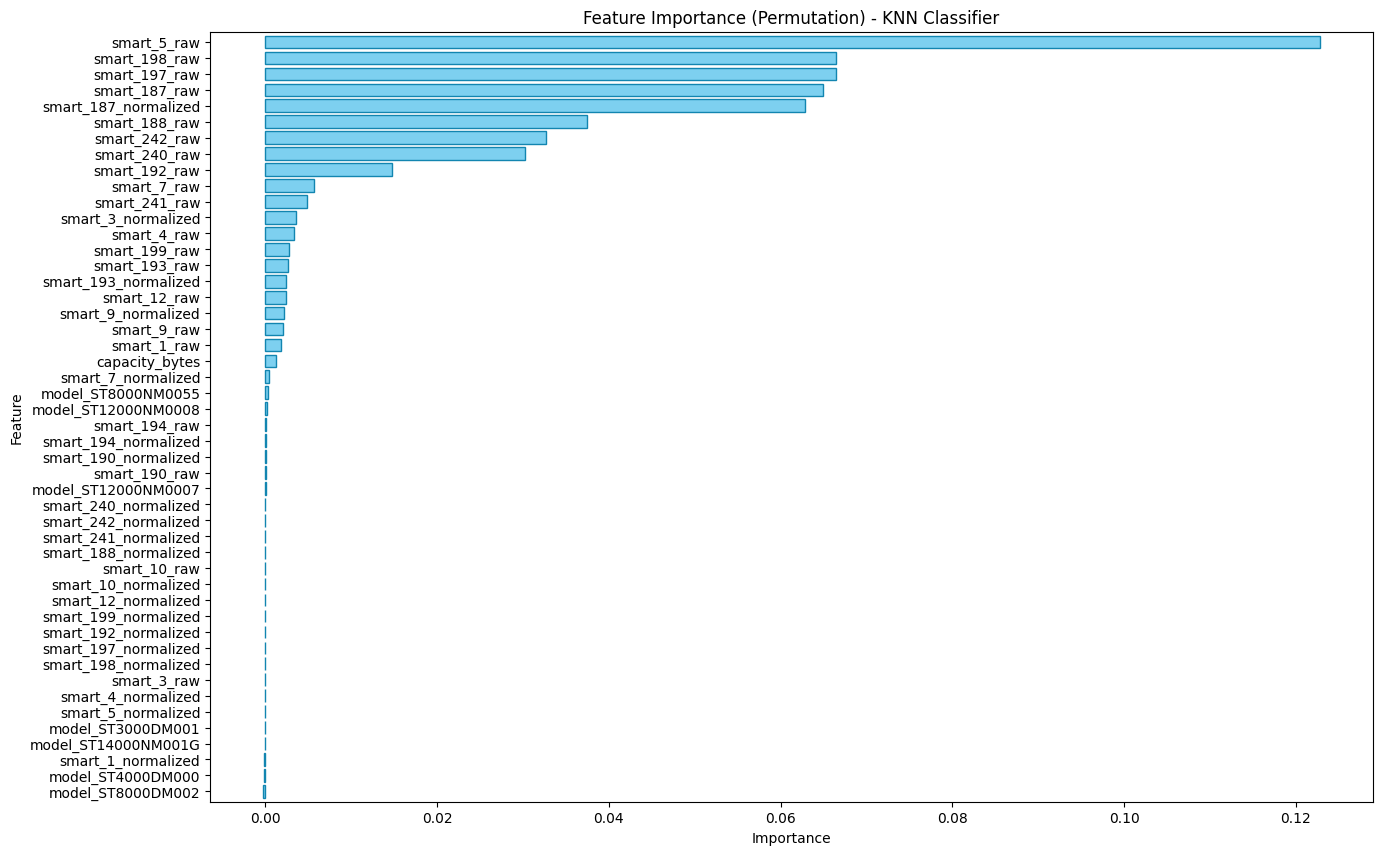

In [30]:
mean_2 = r_2.importances_mean
std_2 = r_2.importances_std
permutation_importances_2 = pd.DataFrame({'mean_importance': mean_2, 'std_importance': std_2}, index=scaled_X_test_2.columns)
permutation_importances_2['feature'] = permutation_importances_2.index
permutation_importances_2.sort_values(by=['mean_importance'], ascending=True, inplace=True)

plt.figure(figsize=(15,10))
fig = permutation_importances_2['mean_importance'].plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation) - KNN Classifier")

print(permutation_importances_2)

0.8634900017682818


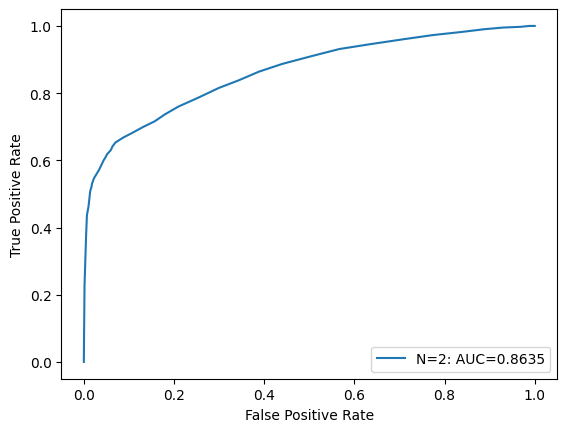

In [31]:
# Calculate AUROC
fpr_2, tpr_2, _ = roc_curve(y_test_2, knn_model_2.predict_proba(scaled_X_test_2)[:,1])
auc_2 = round(roc_auc_score(y_test_2, knn_model_2.predict_proba(scaled_X_test_2)[:,1]), 4)
plt.plot(fpr_2,tpr_2,label="N=2: AUC="+str(auc_2))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_2 = roc_auc_score(y_true=y_test_2, y_score=knn_model_2.predict_proba(scaled_X_test_2)[:,1])
print(auroc_score_2)

Day minus 7

In [32]:
knn_model_7 = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=39, leaf_size=36, algorithm='ball_tree')
knn_model_7.fit(scaled_X_train_7, y_train_7)

test_predictions_7 = knn_model_7.predict(scaled_X_test_7)
cm = confusion_matrix(y_true=y_test_7, y_pred=test_predictions_7)
print(cm)

# Evaluate the model on test set
test_accuracy_7 = knn_model_7.score(scaled_X_test_7, y_test_7)
print("Test Accuracy:", test_accuracy_7)

[[2307  344]
 [ 971 1693]]
Test Accuracy: 0.7525870178739417


In [33]:
from sklearn.inspection import permutation_importance
r_7 = permutation_importance(knn_model_7, scaled_X_test_7, y_test_7,
                           n_repeats=5,
                           random_state=0,
                           scoring='roc_auc')

for i in r_7.importances_mean.argsort()[::-1]:
    if r_7.importances_mean[i] - 2 * r_7.importances_std[i] > 0:
        print(f"{scaled_X_test_7.columns[i]:<8}\t\t"
              f"{r_7.importances_mean[i]:.3f}"
              f" +/- {r_7.importances_std[i]:.3f}")

smart_5_raw		0.111 +/- 0.005
smart_198_raw		0.051 +/- 0.002
smart_197_raw		0.051 +/- 0.002
smart_187_raw		0.049 +/- 0.001
smart_187_normalized		0.044 +/- 0.002
smart_188_raw		0.034 +/- 0.001
smart_240_raw		0.029 +/- 0.002
smart_242_raw		0.027 +/- 0.003
smart_192_raw		0.020 +/- 0.001
smart_241_raw		0.007 +/- 0.002
smart_7_raw		0.005 +/- 0.001
smart_193_raw		0.004 +/- 0.001
smart_193_normalized		0.004 +/- 0.001
smart_12_raw		0.003 +/- 0.001
smart_199_raw		0.003 +/- 0.001
model_ST8000DM002		0.001 +/- 0.000
model_ST12000NM0007		0.001 +/- 0.000
model_ST4000DM000		0.000 +/- 0.000
model_ST14000NM001G		0.000 +/- 0.000


                      mean_importance  std_importance               feature
smart_1_raw                 -0.000324        0.000614           smart_1_raw
smart_194_raw               -0.000183        0.000630         smart_194_raw
smart_190_normalized        -0.000183        0.000630  smart_190_normalized
smart_190_raw               -0.000183        0.000630         smart_190_raw
smart_194_normalized        -0.000183        0.000630  smart_194_normalized
smart_5_normalized          -0.000006        0.000006    smart_5_normalized
smart_3_raw                  0.000000        0.000000           smart_3_raw
smart_4_normalized           0.000000        0.000000    smart_4_normalized
smart_192_normalized         0.000000        0.000000  smart_192_normalized
smart_188_normalized         0.000000        0.000000  smart_188_normalized
smart_197_normalized         0.000000        0.000000  smart_197_normalized
smart_198_normalized         0.000000        0.000000  smart_198_normalized
smart_12_nor

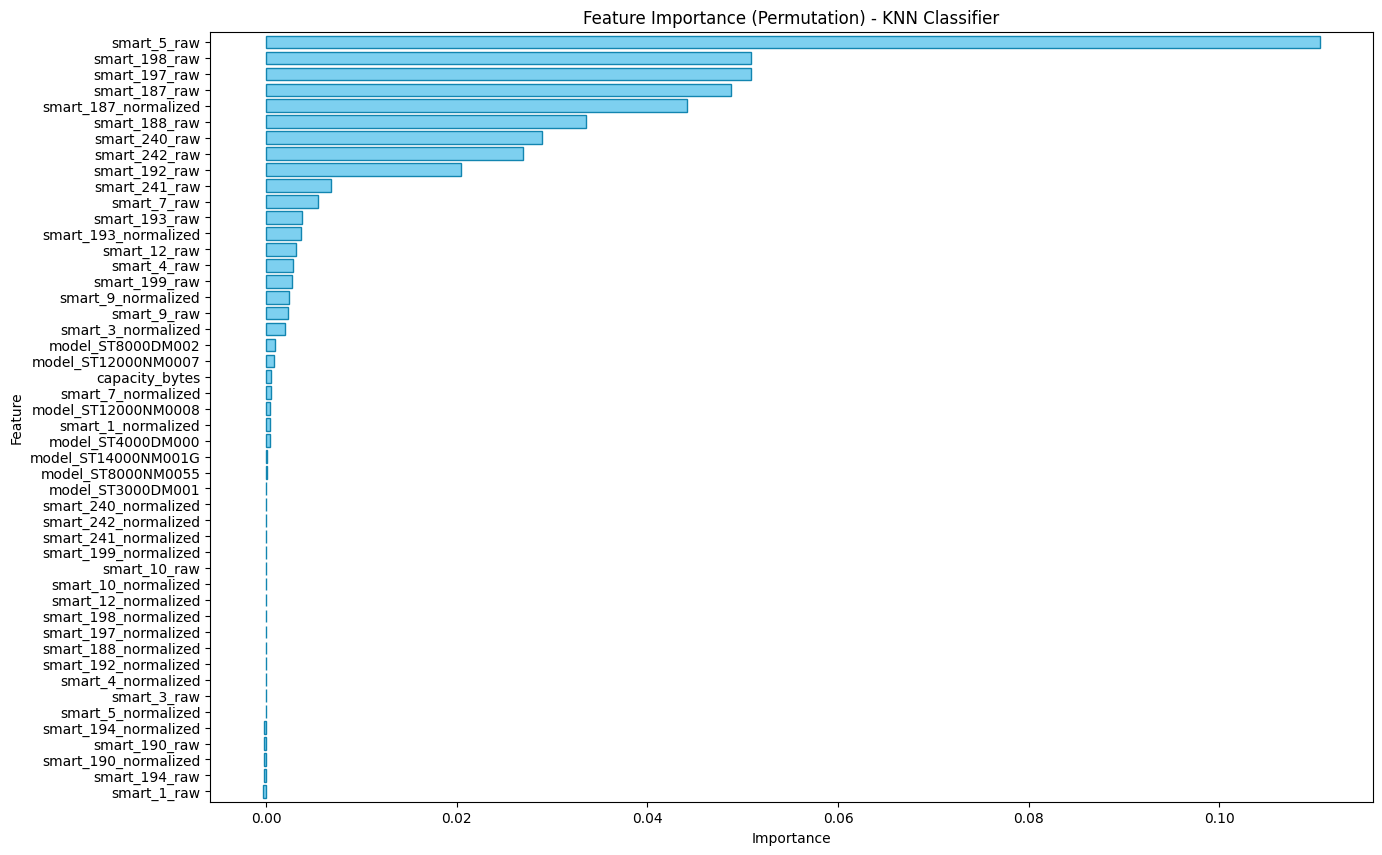

In [35]:
mean_7 = r_7.importances_mean
std_7 = r_7.importances_std
permutation_importances_7 = pd.DataFrame({'mean_importance': mean_7, 'std_importance': std_7}, index=scaled_X_test_7.columns)
permutation_importances_7['feature'] = permutation_importances_7.index
permutation_importances_7.sort_values(by=['mean_importance'], ascending=True, inplace=True)

plt.figure(figsize=(15,10))
fig = permutation_importances_7['mean_importance'].plot.barh(color=[(0.49, 0.816, 0.941)], edgecolor=[(0.071, 0.522, 0.69)], width=0.8, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation) - KNN Classifier")

print(permutation_importances_7)

0.8329216381602274


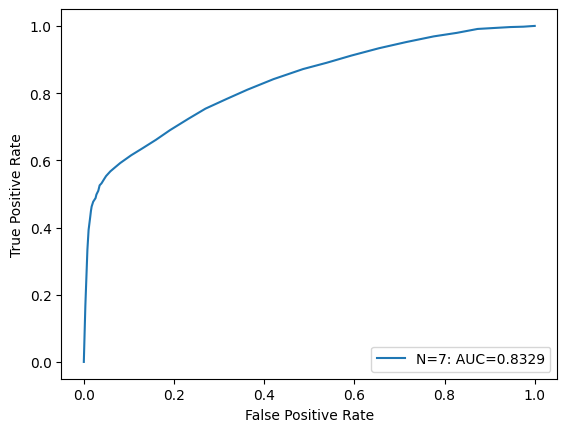

In [36]:
# Calculate AUROC
fpr_7, tpr_7, _ = roc_curve(y_test_7, knn_model_7.predict_proba(scaled_X_test_7)[:,1])
auc_7 = round(roc_auc_score(y_test_7, knn_model_7.predict_proba(scaled_X_test_7)[:,1]), 4)
plt.plot(fpr_7,tpr_7,label="N=7: AUC="+str(auc_7))
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auroc_score_7 = roc_auc_score(y_true=y_test_7, y_score=knn_model_7.predict_proba(scaled_X_test_7)[:,1])
print(auroc_score_7)

Plot ROC curves for each lookahead window

In [37]:
print(auroc_score_0)
print(auroc_score_1)
print(auroc_score_2)
print(auroc_score_7)

0.8756485658377229
0.8556160538285957
0.8634900017682818
0.8329216381602274


In [38]:
from sklearn.model_selection import cross_val_score

cfs_0 = cross_val_score(knn_model_0, scaled_X_test_0, y_test_0, cv=5, scoring='roc_auc')
cfs_1 = cross_val_score(knn_model_1, scaled_X_test_1, y_test_1, cv=5, scoring='roc_auc')
cfs_2 = cross_val_score(knn_model_2, scaled_X_test_2, y_test_2, cv=5, scoring='roc_auc')
cfs_7 = cross_val_score(knn_model_7, scaled_X_test_7, y_test_7, cv=5, scoring='roc_auc')

print(f'N=0: AUROC:{cfs_0.mean()}, STD:{cfs_0.std()}, MAX:{cfs_0.max()}, MIN:{cfs_0.min()}')
print(f'N=1: AUROC:{cfs_1.mean()}, STD:{cfs_1.std()}, MAX:{cfs_1.max()}, MIN:{cfs_1.min()}')
print(f'N=2: AUROC:{cfs_2.mean()}, STD:{cfs_2.std()}, MAX:{cfs_2.max()}, MIN:{cfs_2.min()}')
print(f'N=7: AUROC:{cfs_7.mean()}, STD:{cfs_7.std()}, MAX:{cfs_7.max()}, MIN:{cfs_7.min()}')

N=0: AUROC:0.8617360034353329, STD:0.012115833958830917, MAX:0.8768314391346023, MIN:0.847049220807726
N=1: AUROC:0.841445378511575, STD:0.011113278127879647, MAX:0.8577545076035096, MIN:0.8289415843176499
N=2: AUROC:0.8481799093908895, STD:0.014958808986964198, MAX:0.8620021086113543, MIN:0.8203285567992209
N=7: AUROC:0.817583889959417, STD:0.00875984760790793, MAX:0.833491451024815, MIN:0.809448122057418


Text(0, 0.5, 'True Positive Rate')

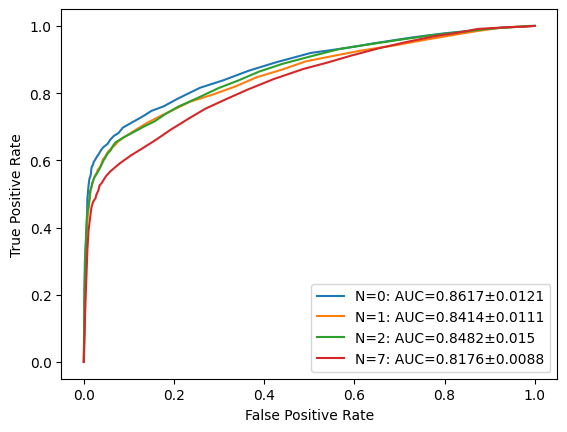

In [39]:
label_0 = f"N=0: AUC={round(cfs_0.mean(), 4)}\u00B1{round(cfs_0.std(), 4)}"
label_1 = f"N=1: AUC={round(cfs_1.mean(), 4)}\u00B1{round(cfs_1.std(), 4)}"
label_2 = f"N=2: AUC={round(cfs_2.mean(), 4):.4f}\u00B1{round(cfs_2.std(), 4)}"
label_7 = f"N=7: AUC={round(cfs_7.mean(), 4)}\u00B1{round(cfs_7.std(), 4)}"

plt.plot(fpr_0,tpr_0,label=label_0)
plt.plot(fpr_1,tpr_1,label=label_1)
plt.plot(fpr_2,tpr_2,label=label_2)
plt.plot(fpr_7,tpr_7,label=label_7)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [40]:
permutation_importances_0 = permutation_importances_0.rename(columns={'mean_importance':'day_minus_0', 'std_importance':'std_importance_0'})
permutation_importances_1 = permutation_importances_1.rename(columns={'mean_importance':'day_minus_1', 'std_importance':'std_importance_1'})
permutation_importances_2 = permutation_importances_2.rename(columns={'mean_importance':'day_minus_2', 'std_importance':'std_importance_2'})
permutation_importances_7 = permutation_importances_7.rename(columns={'mean_importance':'day_minus_7', 'std_importance':'std_importance_7'})

features = permutation_importances_0.merge(permutation_importances_1, on='feature').merge(permutation_importances_2, on='feature').merge(permutation_importances_7, on='feature')

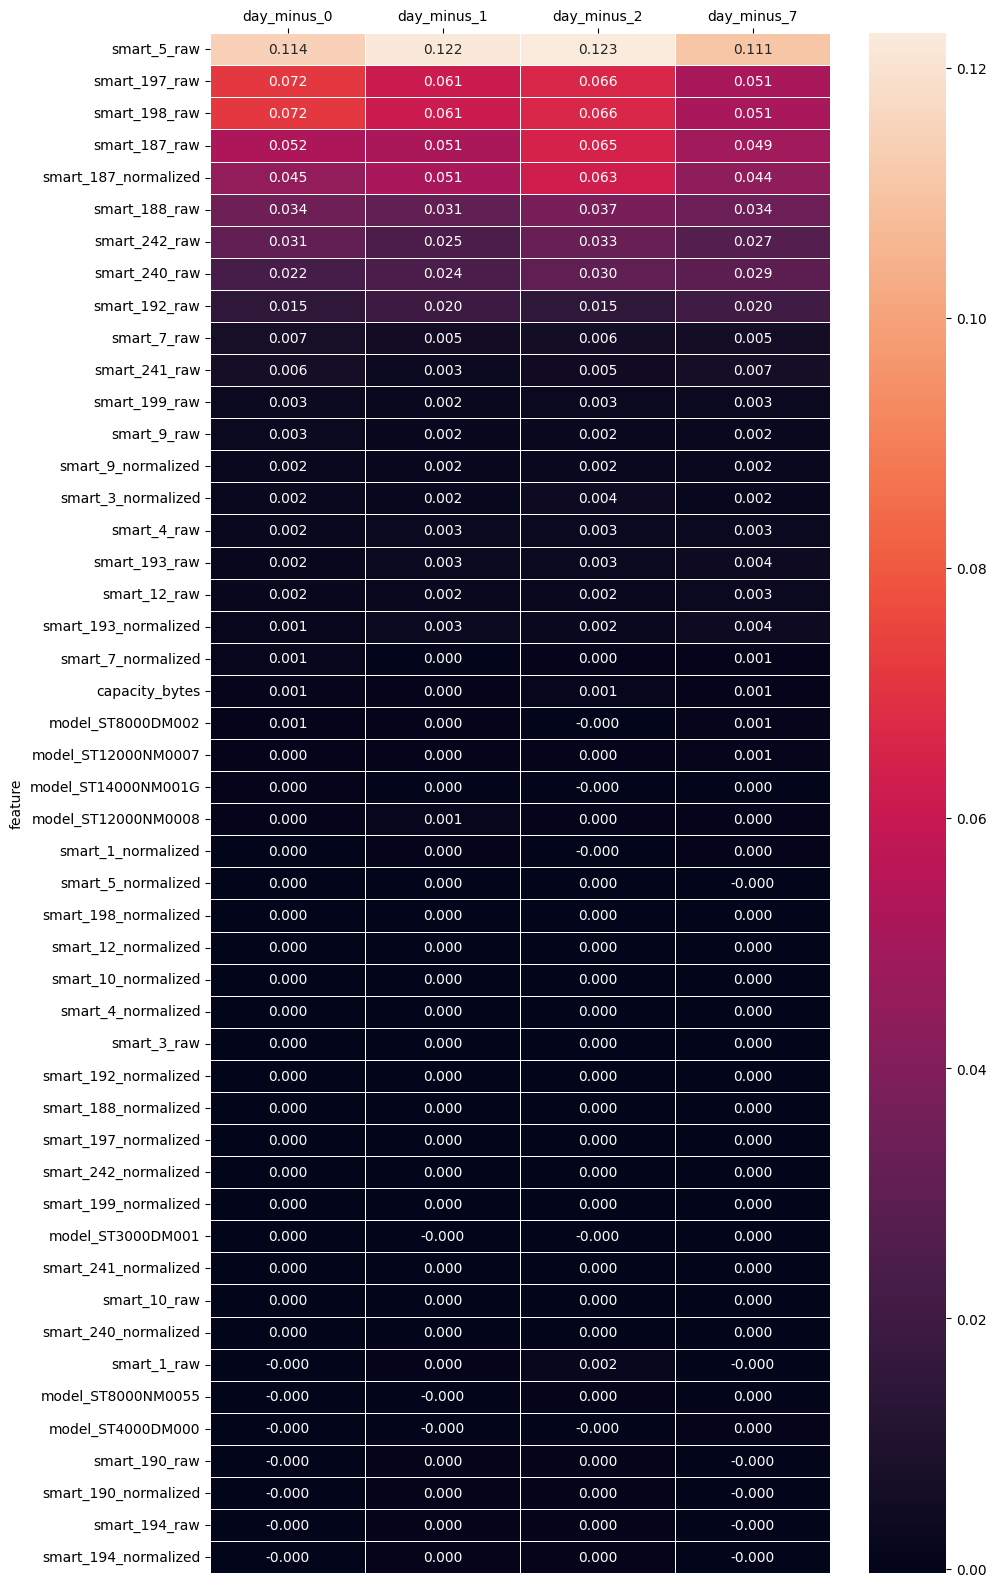

In [41]:
plt.figure(figsize=(10,20))
features.set_index('feature', inplace=True)
features.sort_values('day_minus_0', ascending=False, inplace=True)
heatmap_1 = sns.heatmap(data=features[['day_minus_0', 'day_minus_1', 'day_minus_2', 'day_minus_7']], annot=True, linewidth=.5, fmt=".3f")
heatmap_1.xaxis.tick_top()

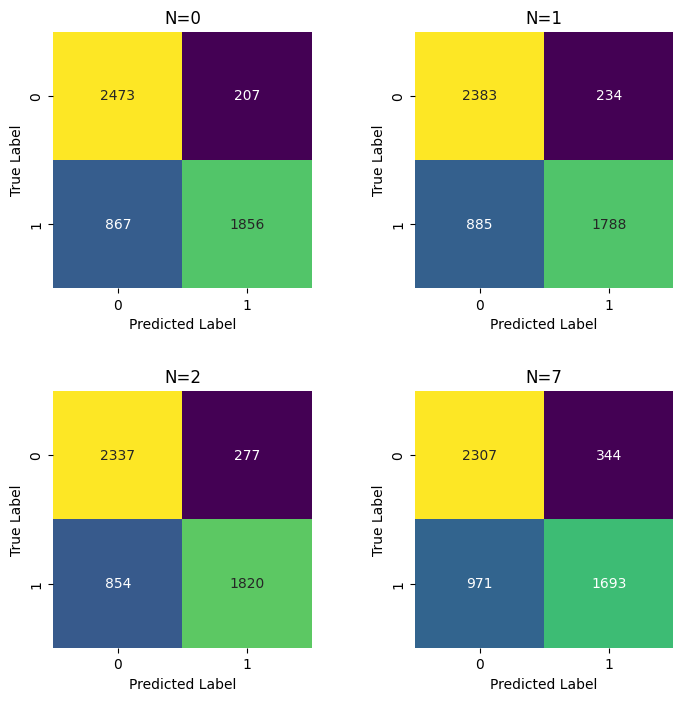

In [45]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

cm_0 = confusion_matrix(y_true=y_test_0, y_pred=test_predictions_0)
cm_1 = confusion_matrix(y_true=y_test_1, y_pred=test_predictions_1)
cm_2 = confusion_matrix(y_true=y_test_2, y_pred=test_predictions_2)
cm_7 = confusion_matrix(y_true=y_test_7, y_pred=test_predictions_7)

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(cm_0, annot=True, fmt='d', cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=0')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax = fig.add_subplot(2, 2, 2)
sns.heatmap(cm_1, annot=True, fmt='d', cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=1')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(cm_2, annot=True, fmt='d',  cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=2')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

ax = fig.add_subplot(2, 2, 4)
sns.heatmap(cm_7, annot=True, fmt='d',  cmap='viridis', cbar=False, ax=ax)
ax.title.set_text('N=7')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test_0, test_predictions_0))
print(classification_report(y_test_1, test_predictions_1))
print(classification_report(y_test_2, test_predictions_2))
print(classification_report(y_test_7, test_predictions_7))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82      2680
           1       0.90      0.68      0.78      2723

    accuracy                           0.80      5403
   macro avg       0.82      0.80      0.80      5403
weighted avg       0.82      0.80      0.80      5403

              precision    recall  f1-score   support

           0       0.73      0.91      0.81      2617
           1       0.88      0.67      0.76      2673

    accuracy                           0.79      5290
   macro avg       0.81      0.79      0.79      5290
weighted avg       0.81      0.79      0.79      5290

              precision    recall  f1-score   support

           0       0.73      0.89      0.81      2614
           1       0.87      0.68      0.76      2674

    accuracy                           0.79      5288
   macro avg       0.80      0.79      0.78      5288
weighted avg       0.80      0.79      0.78      5288

              preci

In [48]:
TP_0 = cm_0[1][1]
TN_0 = cm_0[0][0]
FP_0 = cm_0[0][1]
FN_0 = cm_0[1][0]

TP_1 = cm_1[1][1]
TN_1 = cm_1[0][0]
FP_1 = cm_1[0][1]
FN_1 = cm_1[1][0]

TP_2 = cm_2[1][1]
TN_2 = cm_2[0][0]
FP_2 = cm_2[0][1]
FN_2 = cm_2[1][0]

TP_7 = cm_7[1][1]
TN_7 = cm_7[0][0]
FP_7 = cm_7[0][1]
FN_7 = cm_7[1][0]

cm_paramaters_0 = {'tp': TP_0, 'tn': TN_0, 'fp': FP_0, 'fn': FN_0, 'day':'0'}
cm_paramaters_1 = {'tp': TP_1, 'tn': TN_1, 'fp': FP_1, 'fn': FN_1, 'day':'1'}
cm_paramaters_2 = {'tp': TP_2, 'tn': TN_2, 'fp': FP_2, 'fn': FN_2, 'day':'2'}
cm_paramaters_7 = {'tp': TP_7, 'tn': TN_7, 'fp': FP_7, 'fn': FN_7, 'day':'7'}

cm_parameters = pd.DataFrame([cm_paramaters_0, cm_paramaters_1, cm_paramaters_2, cm_paramaters_7])